In [11]:
import pandas as pd

# File path
file_path = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\bangalore_cars.xlsx"

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path)

# Display first 5 rows
print(df.head())

# Show basic info (columns, datatypes, non-null counts)
print(df.info())

                                      new_car_detail  \
0  {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   
1  {'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...   
2  {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   
3  {'it': 0, 'ft': 'Petrol', 'bt': 'Sedan', 'km':...   
4  {'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...   

                                    new_car_overview  \
0  {'heading': 'Car overview', 'top': [{'key': 'R...   
1  {'heading': 'Car overview', 'top': [{'key': 'R...   
2  {'heading': 'Car overview', 'top': [{'key': 'R...   
3  {'heading': 'Car overview', 'top': [{'key': 'R...   
4  {'heading': 'Car overview', 'top': [{'key': 'R...   

                                     new_car_feature  \
0  {'heading': 'Features', 'top': [{'value': 'Pow...   
1  {'heading': 'Features', 'top': [{'value': 'Pow...   
2  {'heading': 'Features', 'top': [{'value': 'Pow...   
3  {'heading': 'Features', 'top': [{'value': 'Pow...   
4  {'heading': 'Features', 'top': [{'value': '

In [12]:
import pandas as pd
import ast  # safer than eval

# Load Excel file
file_path = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\bangalore_cars.xlsx"
df = pd.read_excel(file_path)

# Convert string dictionaries to real dicts
for col in ["new_car_detail", "new_car_overview", "new_car_feature", "new_car_specs"]:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten new_car_detail
detail_df = pd.json_normalize(df["new_car_detail"])
detail_df.head()

{
  "heading": "Car overview",
  "top": [
    {"key": "Registered Year", "value": "2019"},
    {"key": "Fuel Type", "value": "Petrol"}
  ]
}

def flatten_top_field(col_data, prefix):
    records = []
    for item in col_data:
        temp = {}
        if isinstance(item, dict) and "top" in item:
            for pair in item["top"]:
                if "key" in pair and "value" in pair:
                    temp[pair["key"]] = pair["value"]
                elif "value" in pair:  # feature list (without key)
                    temp.setdefault("Features", []).append(pair["value"])
        records.append(temp)
    return pd.DataFrame(records).add_prefix(prefix + "_")

# Flatten overview, feature, specs
overview_df = flatten_top_field(df["new_car_overview"], "overview")
feature_df = flatten_top_field(df["new_car_feature"], "feature")
specs_df   = flatten_top_field(df["new_car_specs"], "specs")

# Concatenate all flattened parts with original links
final_df = pd.concat([detail_df, overview_df, feature_df, specs_df, df["car_links"]], axis=1)

# Save cleaned dataset
final_df.to_excel("cleaned_bangalore_cars.xlsx", index=False)

print(final_df.head())

   it      ft         bt        km transmission  ownerNo      owner      oem  \
0   0  Petrol  Hatchback  1,20,000       Manual        3  3rd Owner   Maruti   
1   0  Petrol        SUV    32,706       Manual        2  2nd Owner     Ford   
2   0  Petrol  Hatchback    11,949       Manual        1  1st Owner     Tata   
3   0  Petrol      Sedan    17,794       Manual        1  1st Owner  Hyundai   
4   0  Diesel        SUV    60,000       Manual        1  1st Owner   Maruti   

                model  modelYear  ...  overview_Transmission  \
0      Maruti Celerio       2015  ...                 Manual   
1       Ford Ecosport       2018  ...                 Manual   
2          Tata Tiago       2018  ...                 Manual   
3       Hyundai Xcent       2014  ...                 Manual   
4  Maruti SX4 S Cross       2015  ...                 Manual   

  overview_Year of Manufacture  \
0                       2015.0   
1                       2018.0   
2                       2018.0  

In [13]:
import pandas as pd
import ast
import os

def flatten_top_field(col_data, prefix):
    records = []
    for item in col_data:
        temp = {}
        if isinstance(item, dict) and "top" in item:
            for pair in item["top"]:
                if "key" in pair and "value" in pair:
                    temp[pair["key"]] = pair["value"]
                elif "value" in pair:  # features without key
                    temp.setdefault("Features", []).append(pair["value"])
        records.append(temp)
    return pd.DataFrame(records).add_prefix(prefix + "_")

def process_file(file_path, city):
    # Load Excel
    df = pd.read_excel(file_path)

    # Convert string dicts to dicts
    for col in ["new_car_detail", "new_car_overview", "new_car_feature", "new_car_specs"]:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Flatten
    detail_df   = pd.json_normalize(df["new_car_detail"])
    overview_df = flatten_top_field(df["new_car_overview"], "overview")
    feature_df  = flatten_top_field(df["new_car_feature"], "feature")
    specs_df    = flatten_top_field(df["new_car_specs"], "specs")

    # Merge + add City
    final_df = pd.concat([detail_df, overview_df, feature_df, specs_df, df["car_links"]], axis=1)
    final_df["City"] = city
    return final_df

# --------------------------
# Main
# --------------------------
input_folder = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets"
output_folder = os.path.join(input_folder, "Cleaned")
os.makedirs(output_folder, exist_ok=True)

files = {
    "Bangalore": "bangalore_cars.xlsx",
    "Chennai": "chennai_cars.xlsx",
    "Delhi": "delhi_cars.xlsx",
    "Hyderabad": "hyderabad_cars.xlsx",
    "Jaipur": "jaipur_cars.xlsx",
    "Kolkata": "kolkata_cars.xlsx"
}

all_data = []

for city, file in files.items():
    file_path = os.path.join(input_folder, file)
    print(f"Processing {city}...")
    cleaned_df = process_file(file_path, city)
    all_data.append(cleaned_df)

# Concatenate into one master dataset
master_df = pd.concat(all_data, ignore_index=True)

# Save as Excel + CSV
master_excel = os.path.join(output_folder, "all_cities_cleaned.xlsx")
master_csv = os.path.join(output_folder, "all_cities_cleaned.csv")

master_df.to_excel(master_excel, index=False)
master_df.to_csv(master_csv, index=False)

print(f"\n🎉 Master dataset created:\n  {master_excel}\n  {master_csv}")


Processing Bangalore...
Processing Chennai...
Processing Delhi...
Processing Hyderabad...
Processing Jaipur...
Processing Kolkata...

🎉 Master dataset created:
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.xlsx
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.csv


In [19]:
import pandas as pd
import ast
import os
import re

def flatten_top_field(col_data, prefix):
    records = []
    for item in col_data:
        temp = {}
        if isinstance(item, dict) and "top" in item:
            for pair in item["top"]:
                if "key" in pair and "value" in pair:
                    temp[pair["key"]] = pair["value"]
                elif "value" in pair:  # features without key
                    temp.setdefault("Features", []).append(pair["value"])
        records.append(temp)
    return pd.DataFrame(records).add_prefix(prefix + "_")

def process_file(file_path, city):
    # Load Excel
    df = pd.read_excel(file_path)

    # Convert string dicts to dicts
    for col in ["new_car_detail", "new_car_overview", "new_car_feature", "new_car_specs"]:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Flatten
    detail_df   = pd.json_normalize(df["new_car_detail"])
    overview_df = flatten_top_field(df["new_car_overview"], "overview")
    feature_df  = flatten_top_field(df["new_car_feature"], "feature")
    specs_df    = flatten_top_field(df["new_car_specs"], "specs")

    # Merge + add City
    final_df = pd.concat([detail_df, overview_df, feature_df, specs_df, df["car_links"]], axis=1)
    final_df["City"] = city
    return final_df

# --------------------------
# Cleaning Helpers
# --------------------------
def clean_kms(value):
    """Convert strings like '70 kms' -> 70 (int)"""
    if isinstance(value, str):
        value = value.lower().replace("kms", "").replace(",", "").strip()
        value = re.sub(r"[^0-9]", "", value)  # keep only numbers
        return pd.to_numeric(value, errors="coerce")
    return value

def clean_price(value):
    if pd.isna(value):
        return None

    v = str(value).lower().replace(",", "").strip()

    # Handle "lakhs"
    if "lakh" in v:
        num = re.findall(r"[\d\.]+", v)
        return float(num[0]) * 1e5 if num else None

    # Handle "crore" variations ("cr", "crore", "ore", etc.)
    if "cr" in v or "crore" in v or "ore" in v:
        num = re.findall(r"[\d\.]+", v)
        return float(num[0]) * 1e7 if num else None

    # Try direct numeric conversion
    return pd.to_numeric(v, errors="coerce")

def clean_master(df):
    # Ensure lists/dicts in object cols are converted to strings
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (list, dict)) else x)

    # Handle missing values
    categorical_cols = df.select_dtypes(include=["object"]).columns
    numeric_cols = df.select_dtypes(include=["number"]).columns

    for col in numeric_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())  # median imputation

    for col in categorical_cols:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(mode_val)

    # Format cleaning
    for col in df.columns:
        if "km" in col.lower():
            df[col] = df[col].apply(clean_kms)
        if "price" in col.lower():
            df[col] = df[col].apply(clean_price)

    return df

# --------------------------
# Main
# --------------------------
input_folder = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets"
output_folder = os.path.join(input_folder, "Cleaned")
os.makedirs(output_folder, exist_ok=True)

files = {
    "Bangalore": "bangalore_cars.xlsx",
    "Chennai": "chennai_cars.xlsx",
    "Delhi": "delhi_cars.xlsx",
    "Hyderabad": "hyderabad_cars.xlsx",
    "Jaipur": "jaipur_cars.xlsx",
    "Kolkata": "kolkata_cars.xlsx"
}

all_data = []

for city, file in files.items():
    file_path = os.path.join(input_folder, file)
    print(f"Processing {city}...")
    cleaned_df = process_file(file_path, city)
    all_data.append(cleaned_df)

# Concatenate into one master dataset
master_df = pd.concat(all_data, ignore_index=True)

# 🔹 Apply cleaning AFTER merge
master_df = clean_master(master_df)

# Save as Excel + CSV
master_excel = os.path.join(output_folder, "all_cities_cleaned.xlsx")
master_csv = os.path.join(output_folder, "all_cities_cleaned.csv")

master_df.to_excel(master_excel, index=False)
master_df.to_csv(master_csv, index=False)

print(f"\n🎉 Master dataset created & cleaned:\n  {master_excel}\n  {master_csv}")


Processing Bangalore...
Processing Chennai...
Processing Delhi...
Processing Hyderabad...
Processing Jaipur...
Processing Kolkata...

🎉 Master dataset created & cleaned:
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.xlsx
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.csv


In [48]:
import pandas as pd
import ast
import os
import re

def flatten_top_field(col_data, prefix):
    records = []
    for item in col_data:
        temp = {}
        if isinstance(item, dict) and "top" in item:
            for pair in item["top"]:
                if "key" in pair and "value" in pair:
                    temp[pair["key"]] = pair["value"]
                elif "value" in pair:  # features without key
                    temp.setdefault("Features", []).append(pair["value"])
        records.append(temp)
    return pd.DataFrame(records).add_prefix(prefix + "_")

def process_file(file_path, city):
    # Load Excel
    df = pd.read_excel(file_path)

    # Convert string dicts to dicts
    for col in ["new_car_detail", "new_car_overview", "new_car_feature", "new_car_specs"]:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Flatten
    detail_df   = pd.json_normalize(df["new_car_detail"])
    overview_df = flatten_top_field(df["new_car_overview"], "overview")
    feature_df  = flatten_top_field(df["new_car_feature"], "feature")
    specs_df    = flatten_top_field(df["new_car_specs"], "specs")

    # Merge + add City
    final_df = pd.concat([detail_df, overview_df, feature_df, specs_df, df["car_links"]], axis=1)
    final_df["City"] = city
    return final_df

# --------------------------
# Cleaning Helpers
# --------------------------
def clean_kms(value):
    """Convert strings like '70 kms' -> 70 (int)"""
    if isinstance(value, str):
        value = value.lower().replace("kms", "").replace(",", "").strip()
        value = re.sub(r"[^0-9]", "", value)  # keep only numbers
        return pd.to_numeric(value, errors="coerce")
    return value

def clean_price(value):
    if pd.isna(value):
        return None

    v = str(value).lower().replace(",", "").strip()

    # Handle "lakhs"
    if "lakh" in v:
        num = re.findall(r"[\d\.]+", v)
        return float(num[0]) * 1e5 if num else None

    # Handle "crore" variations ("cr", "crore", "ore", etc.)
    if "cr" in v or "crore" in v or "ore" in v:
        num = re.findall(r"[\d\.]+", v)
        return float(num[0]) * 1e7 if num else None

    # Try direct numeric conversion
    return pd.to_numeric(v, errors="coerce")

def extract_year(value):
    """Extract a 4-digit year from strings like 'Feb 2018', 'Sept 2016', etc."""
    if pd.isnull(value):
        return None
    match = re.search(r"(20\d{2}|19\d{2})", str(value))
    if match:
        return int(match.group(0))
    return None

def clean_master(df):
    # Ensure lists/dicts in object cols are converted to strings
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (list, dict)) else x)

    # Handle missing values
    categorical_cols = df.select_dtypes(include=["object"]).columns
    numeric_cols = df.select_dtypes(include=["number"]).columns

    for col in numeric_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())  # median imputation

    for col in categorical_cols:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(mode_val)

    # Format cleaning
    for col in df.columns:
        if "km" in col.lower():
            df[col] = df[col].apply(clean_kms)
        if "price" in col.lower():
            df[col] = df[col].apply(clean_price)

    # ----------------------------
    # 🔹 Registration Year Feature
    # ----------------------------
    if "overview_Registration Year" in df.columns:
        df["registration_year"] = df["overview_Registration Year"].apply(extract_year)

        from datetime import datetime
        current_year = datetime.now().year
        df["car_age"] = current_year - df["registration_year"]

        # Drop messy text column
        df = df.drop(columns=["overview_Registration Year"])

    return df

# --------------------------
# Main
# --------------------------
input_folder = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets"
output_folder = os.path.join(input_folder, "Cleaned")
os.makedirs(output_folder, exist_ok=True)

files = {
    "Bangalore": "bangalore_cars.xlsx",
    "Chennai": "chennai_cars.xlsx",
    "Delhi": "delhi_cars.xlsx",
    "Hyderabad": "hyderabad_cars.xlsx",
    "Jaipur": "jaipur_cars.xlsx",
    "Kolkata": "kolkata_cars.xlsx"
}

all_data = []

for city, file in files.items():
    file_path = os.path.join(input_folder, file)
    print(f"Processing {city}...")
    cleaned_df = process_file(file_path, city)
    all_data.append(cleaned_df)

# Concatenate into one master dataset
master_df = pd.concat(all_data, ignore_index=True)

# 🔹 Apply cleaning AFTER merge
master_df = clean_master(master_df)

# Save as Excel + CSV
master_excel = os.path.join(output_folder, "all_cities_cleaned.xlsx")
master_csv = os.path.join(output_folder, "all_cities_cleaned.csv")

master_df.to_excel(master_excel, index=False)
master_df.to_csv(master_csv, index=False)

print(f"\n🎉 Master dataset created & cleaned:\n  {master_excel}\n  {master_csv}")


Processing Bangalore...
Processing Chennai...
Processing Delhi...
Processing Hyderabad...
Processing Jaipur...
Processing Kolkata...

🎉 Master dataset created & cleaned:
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.xlsx
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.csv


In [2]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

# 🔹 Load cleaned dataset
input_folder = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned"
master_df = pd.read_excel(os.path.join(input_folder, "all_cities_cleaned.xlsx"))

def fast_encode_features(df):
    df_encoded = df.copy()
    
    # Ordinal Encoding for Owner_Type
    if "Owner_Type" in df_encoded.columns:
        owner_map = {"First": 1, "Second": 2, "Third": 3, "Fourth & Above": 4}
        df_encoded["Owner_Type"] = df_encoded["Owner_Type"].map(owner_map).fillna(0).astype(int)
    
    le = LabelEncoder()
    for col in df_encoded.select_dtypes(include=["object"]).columns:
        unique_vals = df_encoded[col].nunique()
        
        if unique_vals <= 10 and col != "Owner_Type":
            # One-Hot Encode for small categorical columns
            dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
            df_encoded = pd.concat([df_encoded.drop(columns=[col]), dummies], axis=1)
        else:
            # Label Encode for large categorical columns
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    
    return df_encoded

# 🔹 Apply encoding
encoded_master = fast_encode_features(master_df)

# Save
output_folder = input_folder  # reuse Cleaned folder
encoded_excel = os.path.join(output_folder, "all_cities_encoded.xlsx")
encoded_csv = os.path.join(output_folder, "all_cities_encoded.csv")

encoded_master.to_excel(encoded_excel, index=False)
encoded_master.to_csv(encoded_csv, index=False)

print(f"\n✅ Encoded dataset saved:\n  {encoded_excel}\n  {encoded_csv}")



✅ Encoded dataset saved:
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_encoded.xlsx
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_encoded.csv


In [ ]:
from sklearn.preprocessing import LabelEncoder

def fast_encode_features(df):
    df_encoded = df.copy()
    
    # Ordinal Encoding for Owner_Type
    if "Owner_Type" in df_encoded.columns:
        owner_map = {"First": 1, "Second": 2, "Third": 3, "Fourth & Above": 4}
        df_encoded["Owner_Type"] = df_encoded["Owner_Type"].map(owner_map).fillna(0).astype(int)
    
    le = LabelEncoder()
    for col in df_encoded.select_dtypes(include=["object"]).columns:
        unique_vals = df_encoded[col].nunique()
        
        if unique_vals <= 10 and col != "Owner_Type":
            # One-Hot Encode for small categorical columns
            dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
            df_encoded = pd.concat([df_encoded.drop(columns=[col]), dummies], axis=1)
        else:
            # Label Encode for large categorical columns
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    
    return df_encoded

# 🔹 Apply encoding
encoded_master = fast_encode_features(master_df)

# Save
encoded_excel = os.path.join(output_folder, "all_cities_encoded.xlsx")
encoded_csv = os.path.join(output_folder, "all_cities_encoded.csv")

encoded_master.to_excel(encoded_excel, index=False)
encoded_master.to_csv(encoded_csv, index=False)

print(f"\n✅ Encoded dataset saved:\n  {encoded_excel}\n  {encoded_csv}")



✅ Encoded dataset saved:
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_encoded.xlsx
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_encoded.csv


In [50]:
from sklearn.preprocessing import LabelEncoder

def fast_encode_features(df):
    df_encoded = df.copy()
    
    # Drop registration_year if redundant
    if "registration_year" in df_encoded.columns:
        df_encoded = df_encoded.drop(columns=["registration_year"])
    
    # Ordinal Encoding for Owner_Type
    if "Owner_Type" in df_encoded.columns:
        owner_map = {"First": 1, "Second": 2, "Third": 3, "Fourth & Above": 4}
        df_encoded["Owner_Type"] = df_encoded["Owner_Type"].map(owner_map).fillna(0).astype(int)
    
    le = LabelEncoder()
    for col in df_encoded.select_dtypes(include=["object"]).columns:
        unique_vals = df_encoded[col].nunique()
        
        if unique_vals <= 10 and col != "Owner_Type":
            # One-Hot Encode for small categorical columns
            dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
            df_encoded = pd.concat([df_encoded.drop(columns=[col]), dummies], axis=1)
        else:
            # Label Encode for large categorical columns
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    
    return df_encoded


# 🔹 Apply encoding
encoded_master = fast_encode_features(master_df)

# Save
encoded_excel = os.path.join(output_folder, "all_cities_encoded.xlsx")
encoded_csv = os.path.join(output_folder, "all_cities_encoded.csv")

encoded_master.to_excel(encoded_excel, index=False)
encoded_master.to_csv(encoded_csv, index=False)

print(f"\n✅ Encoded dataset saved:\n  {encoded_excel}\n  {encoded_csv}")


✅ Encoded dataset saved:
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_encoded.xlsx
  D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_encoded.csv


In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

def scale_features(df, method="minmax"):
    df_scaled = df.copy()
    numeric_cols = df_scaled.select_dtypes(include=[np.number]).columns
    
    if method == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    
    df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
    return df_scaled

def remove_outliers_iqr(df, cols=None):
    df_clean = df.copy()
    if cols is None:
        cols = df_clean.select_dtypes(include=[np.number]).columns
    
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

In [49]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

def scale_features(df, method="minmax", exclude_cols=None):
    df_scaled = df.copy()
    numeric_cols = df_scaled.select_dtypes(include=[np.number]).columns
    
    # Exclude unwanted numeric columns if specified (like IDs)
    if exclude_cols:
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    if method == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    
    df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
    return df_scaled

def remove_outliers_iqr(df, cols=None):
    df_clean = df.copy()
    if cols is None:
        cols = df_clean.select_dtypes(include=[np.number]).columns
    
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    
    return df_clean


In [8]:
# Load your encoded dataset
encoded_master = pd.read_excel(r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_encoded.xlsx")

# Step 1: Remove outliers
cleaned_no_outliers = remove_outliers_iqr(encoded_master, cols=["price", "km"])

# Step 2: Scale features
scaled_master = scale_features(cleaned_no_outliers, method="minmax")

scaled_master.head()

c:\Users\BERLIN SAMUEL RAJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_array_api.py:686: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\BERLIN SAMUEL RAJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_array_api.py:706: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


,it,km,ownerNo,oem,model,modelYear,centralVariantId,variantName,price,priceActual,...,overview_Ownership_First Owner,overview_Ownership_Fourth Owner,overview_Ownership_Second Owner,overview_Ownership_Third Owner,overview_Transmission_Manual,City_Chennai,City_Delhi,City_Hyderabad,City_Jaipur,City_Kolkata
0,0.0,0.800000,0.6,0.62500,0.509554,0.789474,0.358244,0.839219,0.179104,NaN,...,False,False,False,True,True,False,False,False,False,False
1,0.0,0.218040,0.4,0.18750,0.159236,0.868421,0.548274,0.133829,0.424478,NaN,...,False,False,True,False,True,False,False,False,False,False
2,0.0,0.079660,0.2,0.90625,0.869427,0.868421,0.268458,0.059944,0.289552,NaN,...,True,False,False,False,True,False,False,False,False,False
3,0.0,0.118627,0.2,0.28125,0.277070,0.763158,0.167854,0.046933,0.216119,NaN,...,True,False,False,False,True,False,False,False,False,False
4,0.0,0.400000,0.2,0.62500,0.566879,0.789474,0.385108,0.458643,0.411940,NaN,...,True,False,False,False,True,False,False,False,False,False


In [7]:
print(encoded_master.columns)

Index(['it', 'km', 'ownerNo', 'oem', 'model', 'modelYear', 'centralVariantId',
       'variantName', 'price', 'priceActual', 'priceSaving', 'priceFixedText',
       'overview_Registration Year', 'overview_Kms Driven', 'overview_RTO',
       'overview_Engine Displacement', 'overview_Year of Manufacture',
       'feature_Features', 'specs_Mileage', 'specs_Engine', 'specs_Max Power',
       'specs_Torque', 'specs_Seats', 'specs_Wheel Size', 'car_links',
       'ft_Diesel', 'ft_Electric', 'ft_Lpg', 'ft_Petrol', 'bt_Coupe',
       'bt_Hatchback', 'bt_Hybrids', 'bt_MUV', 'bt_Minivans',
       'bt_Pickup Trucks', 'bt_SUV', 'bt_Sedan', 'bt_Wagon',
       'transmission_Manual', 'owner_1st Owner', 'owner_2nd Owner',
       'owner_3rd Owner', 'owner_4th Owner', 'owner_5th Owner',
       'overview_Insurance Validity_2',
       'overview_Insurance Validity_Comprehensive',
       'overview_Insurance Validity_Not Available',
       'overview_Insurance Validity_Third Party',
       'overview_Insurance

In [9]:
import pandas as pd

# Load dataset
df = scaled_master.copy()  # Or original encoded_master if you want raw values

# Summary statistics
desc_stats = df.describe().T  # Transpose for easier reading
desc_stats['median'] = df.median()
desc_stats['mode'] = df.mode().iloc[0]  # First mode
desc_stats['std'] = df.std()

desc_stats


,count,mean,std,min,25%,50%,75%,max,median,mode
it,7328.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
km,7328.0,0.390500,0.217286,0.0,0.215670,0.369343,0.533333,1.0,0.369343,0.8
ownerNo,7328.0,0.273690,0.128597,0.0,0.200000,0.200000,0.400000,1.0,0.200000,0.2
oem,7328.0,0.509352,0.256599,0.0,0.281250,0.625000,0.625000,1.0,0.625000,0.625
model,7328.0,0.457914,0.244104,0.0,0.245223,0.487261,0.582803,1.0,0.487261,0.200637
modelYear,7328.0,0.826017,0.098446,0.0,0.763158,0.842105,0.894737,1.0,0.842105,0.868421
centralVariantId,7328.0,0.440512,0.245364,0.0,0.176237,0.458938,0.638781,1.0,0.458938,0.937348
variantName,7328.0,0.544669,0.314329,0.0,0.226185,0.591543,0.839219,1.0,0.591543,0.839219
price,7328.0,0.320490,0.211771,0.0,0.167164,0.275821,0.418507,1.0,0.275821,0.328358
priceActual,1662.0,0.269198,0.140304,0.0,0.172414,0.252874,0.339988,1.0,0.252874,0.222626


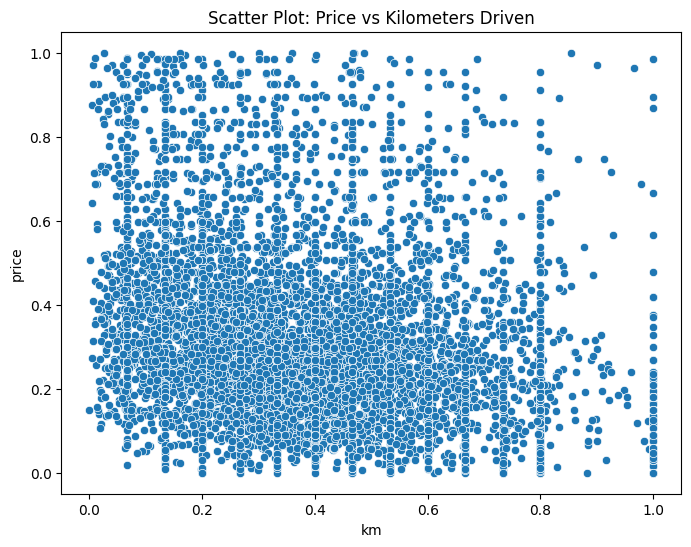

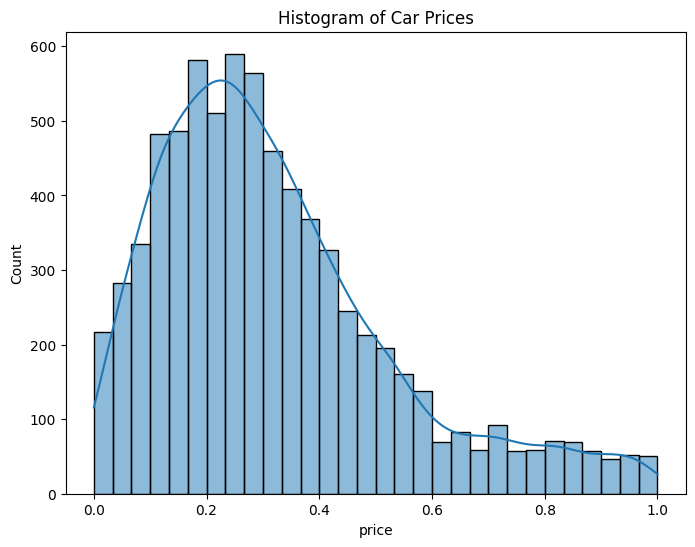

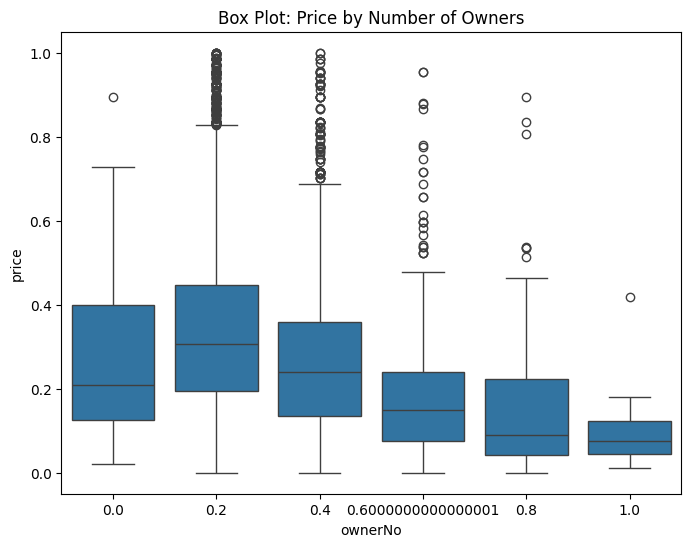

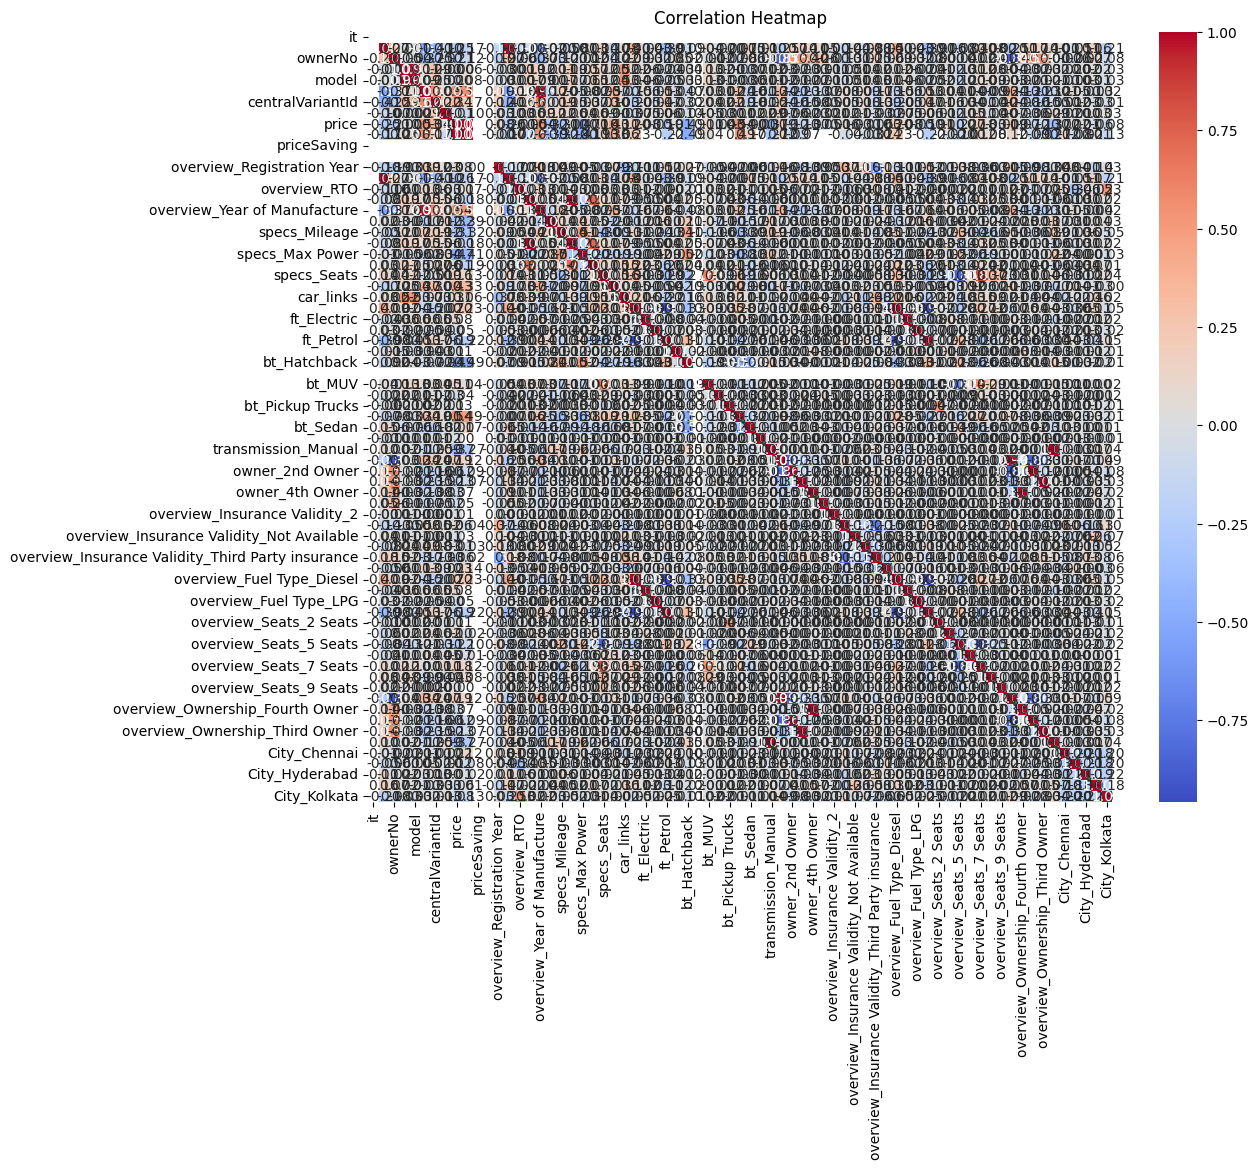

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: price vs km
plt.figure(figsize=(8,6))
sns.scatterplot(x='km', y='price', data=df)
plt.title('Scatter Plot: Price vs Kilometers Driven')
plt.show()

# Histogram: Price distribution
plt.figure(figsize=(8,6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Histogram of Car Prices')
plt.show()

# Box plot: Price by Owner
plt.figure(figsize=(8,6))
sns.boxplot(x='ownerNo', y='price', data=df)
plt.title('Box Plot: Price by Number of Owners')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()


In [11]:
# Find features highly correlated with price
cor_target = corr_matrix['price'].sort_values(ascending=False)
print(cor_target)


price                           1.000000
priceActual                     0.995864
overview_Year of Manufacture    0.538227
bt_SUV                          0.537576
modelYear                       0.532207
                                  ...   
bt_Hatchback                   -0.494675
it                                   NaN
priceSaving                          NaN
priceFixedText                       NaN
bt_Hybrids                           NaN
Name: price, Length: 71, dtype: float64


In [12]:
from sklearn.ensemble import RandomForestRegressor

# Split features and target
X = df.drop(columns=['price'])
y = df['price']

# Train a simple Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances.head(20))  # Top 20 features


specs_Max Power                 0.441381
modelYear                       0.173202
specs_Wheel Size                0.102814
overview_Year of Manufacture    0.076032
specs_Torque                    0.024794
centralVariantId                0.022299
variantName                     0.015391
overview_RTO                    0.012721
specs_Mileage                   0.012532
overview_Registration Year      0.012408
car_links                       0.010900
priceActual                     0.008499
feature_Features                0.008284
model                           0.008171
specs_Engine                    0.008163
overview_Engine Displacement    0.007797
km                              0.007289
overview_Kms Driven             0.007086
City_Kolkata                    0.005138
bt_SUV                          0.004668
dtype: float64


=== Descriptive Statistics ===
                               count           mean           std       min  \
it                            8259.0       0.000000  0.000000e+00       0.0   
km                            8259.0   58647.328732  7.437559e+04       0.0   
ownerNo                       8259.0       1.349921  6.295315e-01       0.0   
oem                           8259.0      16.185979  8.527862e+00       0.0   
model                         8259.0     143.628769  7.960731e+01       0.0   
modelYear                     8259.0    2016.642814  3.736124e+00    1985.0   
centralVariantId              8259.0    4988.694999  2.750532e+03       5.0   
variantName                   8259.0    1159.185131  6.618972e+02       0.0   
price                         8259.0  968756.871292  1.421848e+06  100000.0   
priceActual                   8259.0  567990.979537  1.133360e+05  142000.0   
priceSaving                      0.0            NaN           NaN       NaN   
priceFixedText       

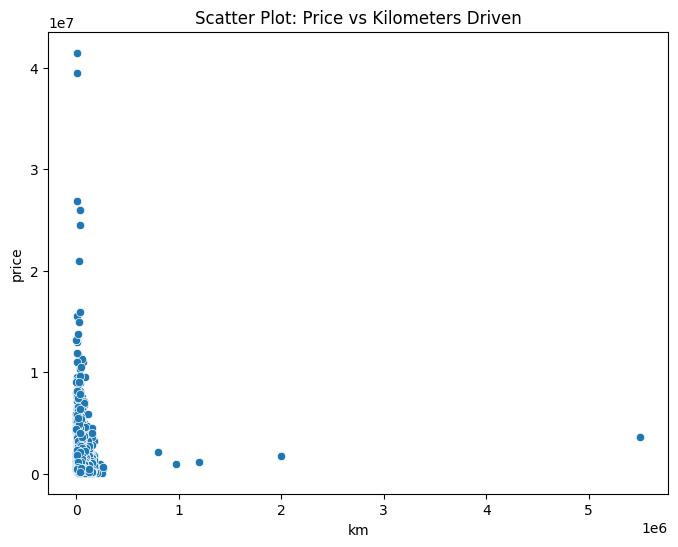

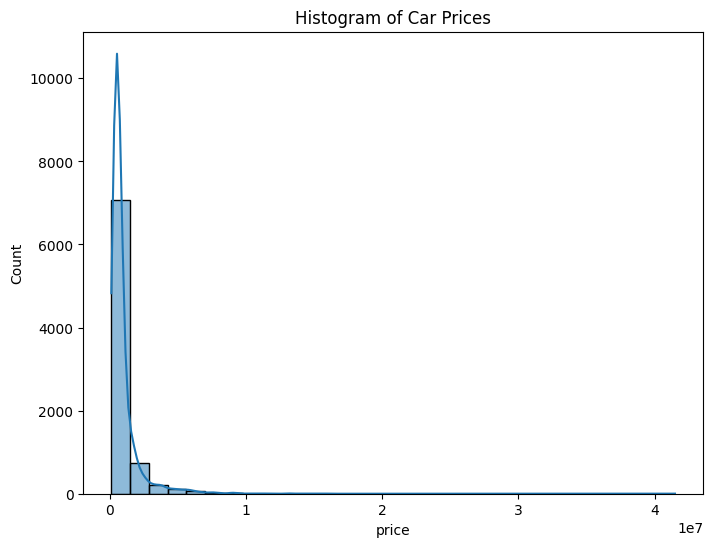

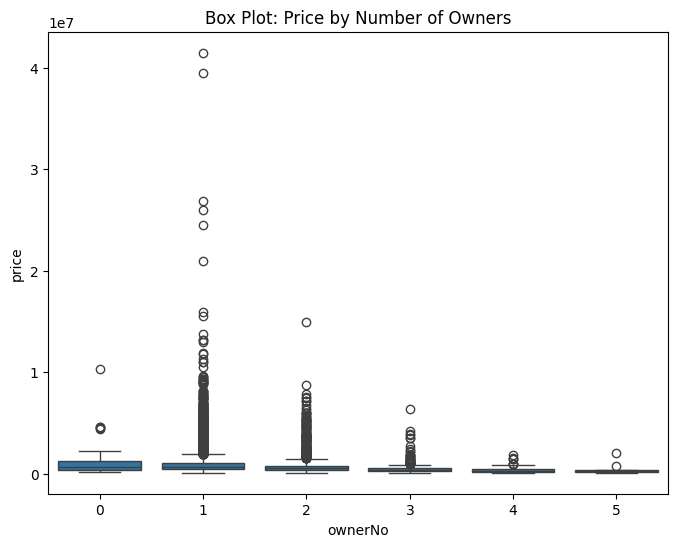

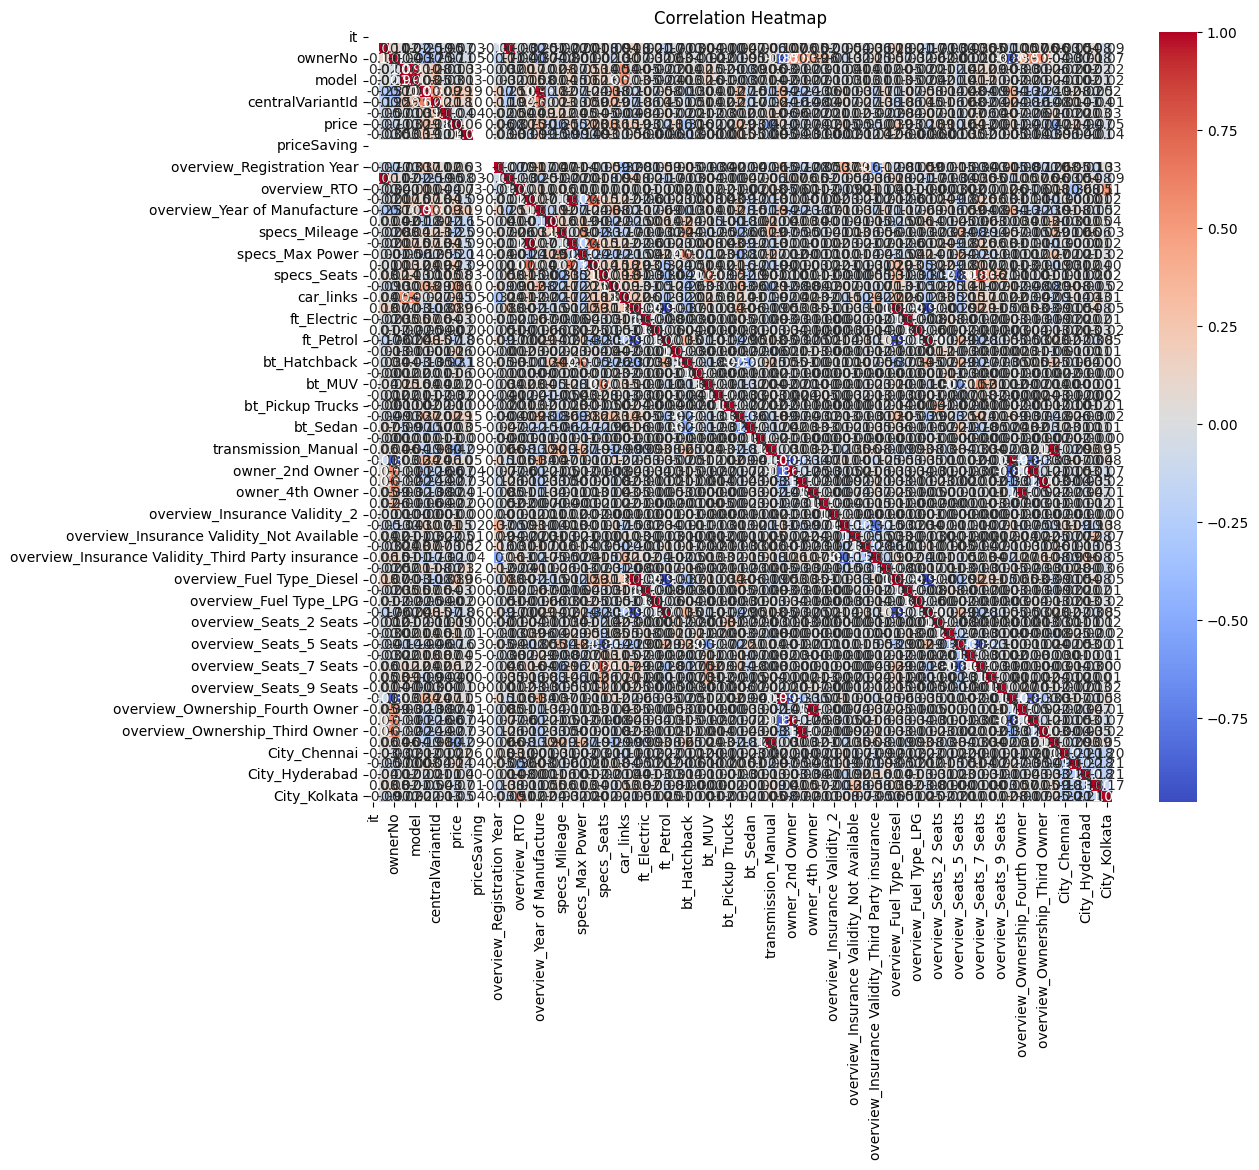

=== Features Correlated with Price ===
price                           1.000000
specs_Wheel Size                0.355762
overview_Year of Manufacture    0.296592
modelYear                       0.293498
bt_SUV                          0.287312
                                  ...   
transmission_Manual            -0.419824
overview_Transmission_Manual   -0.419824
it                                   NaN
priceSaving                          NaN
priceFixedText                       NaN
Name: price, Length: 71, dtype: float64
=== Top 20 Feature Importances ===
specs_Wheel Size                0.276541
specs_Torque                    0.155151
specs_Max Power                 0.138159
variantName                     0.073411
modelYear                       0.043251
overview_Kms Driven             0.040048
feature_Features                0.032467
km                              0.030667
car_links                       0.030129
specs_Mileage                   0.028590
overview_Year of Manufact

In [ ]:
# ---------------------------
# Car Dataset EDA Script
# ---------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# ---------------------------
# Load Dataset
# ---------------------------
df = pd.read_excel(r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_encoded.xlsx")

# Strip column spaces
df.columns = df.columns.str.strip()

# ---------------------------
# Handle missing values
# ---------------------------
# Drop rows with missing target (price)
df = df.dropna(subset=['price'])

# Fill missing values in numeric features with median
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('price')  # Exclude target
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# ---------------------------
# Descriptive Statistics
# ---------------------------
desc_stats = df.describe().T
desc_stats['median'] = df.median()
desc_stats['mode'] = df.mode().iloc[0]
desc_stats['std'] = df.std()

print("=== Descriptive Statistics ===")
print(desc_stats)

# ---------------------------
# Visualizations
# ---------------------------

# Scatter plot: price vs km
if 'km' in df.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='km', y='price', data=df)
    plt.title('Scatter Plot: Price vs Kilometers Driven')
    plt.show()

# Histogram: Price distribution
plt.figure(figsize=(8,6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Histogram of Car Prices')
plt.show()

# Box plot: Price by Owner
if 'ownerNo' in df.columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='ownerNo', y='price', data=df)
    plt.title('Box Plot: Price by Number of Owners')
    plt.show()

# Correlation heatmap
plt.figure(figsize=(12,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

# ---------------------------
# Feature Selection
# ---------------------------

# Correlation with target (price)
cor_target = corr_matrix['price'].sort_values(ascending=False)
print("=== Features Correlated with Price ===")
print(cor_target)

# Feature importance using Random Forest
X = df.select_dtypes(include=[np.number]).drop(columns=['price'])
y = df['price']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("=== Top 20 Feature Importances ===")
print(feature_importances.head(20))


In [15]:
from sklearn.model_selection import train_test_split

# Assume df is cleaned and numeric features are prepared
X = df.select_dtypes(include=[np.number]).drop(columns=['price'])
y = df['price']

# Split dataset: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [21]:
import pandas as pd
import numpy as np

# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('price')  # exclude target

X = df[numeric_cols]
y = df['price']

# Remove columns that are entirely NaN
X = X.dropna(axis=1, how='all')

# Replace inf/-inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill remaining NaNs with median
X = X.fillna(X.median())

# Ensure no NaNs remain
print("Remaining NaNs per column:\n", X.isnull().sum())


Remaining NaNs per column:
 it                              0
km                              0
ownerNo                         0
oem                             0
model                           0
modelYear                       0
centralVariantId                0
variantName                     0
priceActual                     0
overview_Registration Year      0
overview_Kms Driven             0
overview_RTO                    0
overview_Engine Displacement    0
overview_Year of Manufacture    0
feature_Features                0
specs_Mileage                   0
specs_Engine                    0
specs_Max Power                 0
specs_Torque                    0
specs_Seats                     0
specs_Wheel Size                0
car_links                       0
dtype: int64


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute RMSE manually for older sklearn versions
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    r2 = r2_score(y_test, y_pred)
    print(f"{name} --> RMSE: {rmse:.2f}, R2: {r2:.2f}")


Linear Regression --> RMSE: 1179578.22, R2: 0.27
Decision Tree --> RMSE: 746383.65, R2: 0.71
Random Forest --> RMSE: 686793.64, R2: 0.75
Gradient Boosting --> RMSE: 758664.49, R2: 0.70


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest --> RMSE: 106471.34, R2: 0.91
5-Fold CV R2 Scores: [0.808205   0.91173868 0.91044998 0.89370498 0.82226095]
Mean CV R2: 0.87


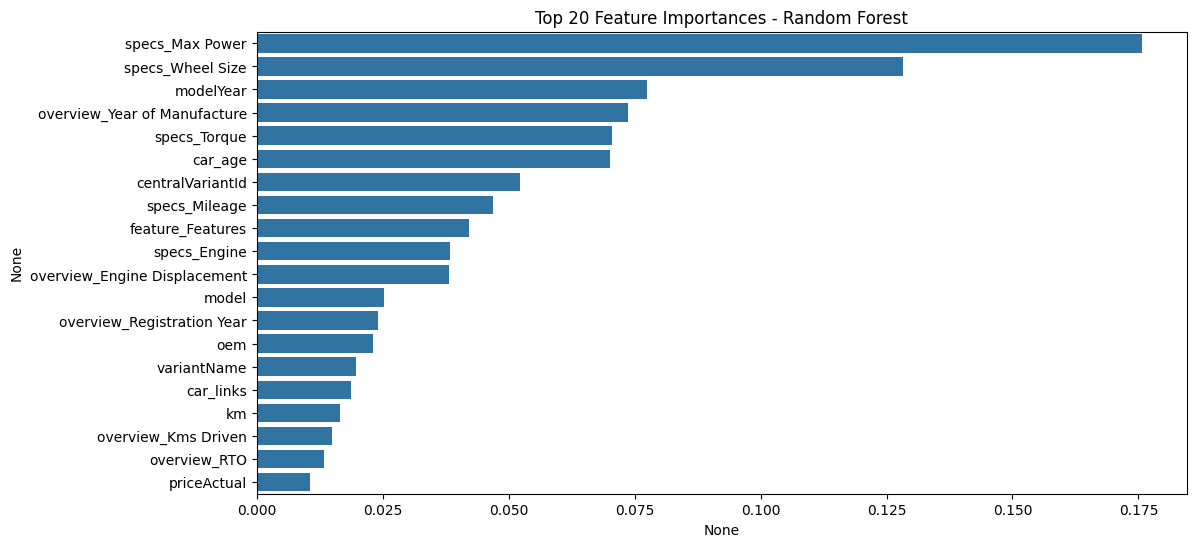

In [25]:
# ---------------------------
# Libraries
# ---------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Load Data
# ---------------------------
df = pd.read_excel(r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_encoded.xlsx")

# ---------------------------
# Feature Engineering
# ---------------------------
# Car Age
if 'modelYear' in df.columns:
    df['car_age'] = 2025 - df['modelYear']  # adjust year accordingly

# Mileage per Year
if 'overview_Kms Driven' in df.columns and 'car_age' in df.columns:
    df['mileage_per_year'] = df['overview_Kms Driven'] / df['car_age']
    
# ---------------------------
# Outlier Handling
# ---------------------------
def remove_outliers_iqr(df, cols=None):
    df_clean = df.copy()
    if cols is None:
        cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('price')  # target
df_clean = remove_outliers_iqr(df, cols=['price', 'overview_Kms Driven', 'car_age', 'mileage_per_year'])

# ---------------------------
# Prepare Features
# ---------------------------
X = df_clean[numeric_cols]
y = df_clean['price']

# Drop columns with all NaN
X = X.dropna(axis=1, how='all')

# Replace inf/-inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill remaining NaNs with median
X = X.fillna(X.median())

# ---------------------------
# Train-Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# Random Forest Hyperparameter Tuning
# ---------------------------
rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None] 
}

rf_random = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, n_iter=20,
    scoring='r2', cv=5, verbose=2, random_state=42, n_jobs=-1
)

rf_random.fit(X_train, y_train)

best_rf = rf_random.best_estimator_

# ---------------------------
# Model Evaluation
# ---------------------------
y_pred = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Best Random Forest --> RMSE: {rmse:.2f}, R2: {r2:.2f}")

# Cross-Validation Score
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')
print(f"5-Fold CV R2 Scores: {cv_scores}")
print(f"Mean CV R2: {cv_scores.mean():.2f}")

# ---------------------------
# Feature Importance
# ---------------------------
feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=feat_importances[:20], y=feat_importances.index[:20])
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()


In [40]:
# ---------------------------
# IMPORTS
# ---------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# LOAD DATA
# ---------------------------
file_path = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.xlsx"
df = pd.read_excel(file_path)

# ---------------------------
# TARGET & FEATURES
# ---------------------------
target = 'price'
df = df.dropna(subset=[target])
X = df.drop(columns=[target])
y = df[target]

# ---------------------------
# HANDLE NAN / INF
# ---------------------------
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Numeric columns
numeric_cols = X.select_dtypes(include=np.number).columns
for col in numeric_cols:
    median_val = X[col].median()
    if np.isnan(median_val):
        median_val = 0
    X[col].fillna(median_val, inplace=True)

# Categorical columns
categorical_cols = X.select_dtypes(exclude=np.number).columns
for col in categorical_cols:
    mode_val = X[col].mode()
    if mode_val.empty:
        X[col].fillna('Unknown', inplace=True)
    else:
        X[col].fillna(mode_val[0], inplace=True)

# Verify
missing = X.isnull().sum().sum()
print(f"Total missing values after preprocessing: {missing}")
assert missing == 0, "There are still NaNs in X!"

# ---------------------------
# TRAIN-TEST SPLIT
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# PREPROCESSOR
# ---------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# ---------------------------
# RANDOM FOREST PIPELINE
# ---------------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# ---------------------------
# HYPERPARAMETERS
# ---------------------------
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2']
}

# ---------------------------
# RANDOMIZED SEARCH
# ---------------------------
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=5,  # fewer iterations for speed
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

# ---------------------------
# EVALUATION
# ---------------------------
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
cv_scores = cross_val_score(best_model, X, y, cv=3, scoring='r2')

print("\n--- Random Forest ---")
print(f"RMSE: {rmse:.2f}, R2: {r2:.2f}")
print(f"3-Fold CV R2 Scores: {cv_scores}")
print(f"Mean CV R2: {cv_scores.mean():.2f}")

# ---------------------------
# SAVE MODEL
# ---------------------------
import joblib
joblib.dump(best_model, 'best_random_forest_model.pkl')
print("\nRandom Forest model saved as 'best_random_forest_model.pkl'")



Total missing values after preprocessing: 0

--- Random Forest ---
RMSE: 828098.12, R2: 0.64
3-Fold CV R2 Scores: [0.83997643 0.49085554 0.73750537]
Mean CV R2: 0.69

Random Forest model saved as 'best_random_forest_model.pkl'


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred = best_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Evaluation Metrics ---")
print(f"MAE : {mae:.2f}")
print(f"MSE : {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")


--- Evaluation Metrics ---
MAE : 173431.38
MSE : 685746500365.97
RMSE: 828098.12
R²  : 0.64


In [42]:
import pandas as pd

# Example: if results dict already stores multiple models
# results = { 'Random Forest': {...}, 'Gradient Boosting': {...}, ... }

results_df = pd.DataFrame([
    {
        "Model": name,
        "RMSE": vals["RMSE"],
        "R2": vals["R2"],
        "Mean CV R2": vals["Mean CV R2"]
    }
    for name, vals in results.items()
])

print("\n--- Model Comparison ---")
print(results_df)


--- Model Comparison ---
           Model           RMSE        R2  Mean CV R2
0  Random Forest  823139.642938  0.644558    0.649373


In [46]:
# ---------------------------
# IMPORTS
# ---------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# LOAD DATA
# ---------------------------
file_path = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.xlsx"
df = pd.read_excel(file_path)

# ---------------------------
# FEATURE ENGINEERING
# ---------------------------

# Car age from model year
df['car_age'] = datetime.now().year - df['modelYear']
# Only add this if you actually have both 'power' and 'weight' columns
if 'power' in df.columns and 'weight' in df.columns:
    df['power_to_weight'] = df['power'] / df['weight']

# ---------------------------
# TARGET & FEATURES
# ---------------------------
target = 'price'
df = df.dropna(subset=[target])
X = df.drop(columns=[target])
y = df[target]

# ---------------------------
# HANDLE NAN / INF
# ---------------------------
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Numeric columns
numeric_cols = X.select_dtypes(include=np.number).columns
for col in numeric_cols:
    median_val = X[col].median()
    if np.isnan(median_val):
        median_val = 0
    X[col].fillna(median_val, inplace=True)

# Categorical columns
categorical_cols = X.select_dtypes(exclude=np.number).columns
for col in categorical_cols:
    mode_val = X[col].mode()
    if mode_val.empty:
        X[col].fillna('Unknown', inplace=True)
    else:
        X[col].fillna(mode_val[0], inplace=True)

# Verify
missing = X.isnull().sum().sum()
print(f"Total missing values after preprocessing: {missing}")
assert missing == 0, "There are still NaNs in X!"

# ---------------------------
# TRAIN-TEST SPLIT
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# PREPROCESSOR
# ---------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# ---------------------------
# RANDOM FOREST PIPELINE
# ---------------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# ---------------------------
# HYPERPARAMETERS
# ---------------------------
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2']
}

# ---------------------------
# RANDOMIZED SEARCH
# ---------------------------
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=5,  # fewer iterations for speed
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

# ---------------------------
# EVALUATION
# ---------------------------
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
cv_scores = cross_val_score(best_model, X, y, cv=3, scoring='r2')

print("\n--- Random Forest ---")
print(f"RMSE: {rmse:.2f}, R2: {r2:.2f}")
print(f"3-Fold CV R2 Scores: {cv_scores}")
print(f"Mean CV R2: {cv_scores.mean():.2f}")

# ---------------------------
# SAVE MODEL
# ---------------------------
import joblib
joblib.dump(best_model, 'best_random_forest_model.pkl')
print("\nRandom Forest model saved as 'best_random_forest_model.pkl'")




Total missing values after preprocessing: 0

--- Random Forest ---
RMSE: 785836.99, R2: 0.68
3-Fold CV R2 Scores: [0.84525341 0.47131994 0.77203855]
Mean CV R2: 0.70

Random Forest model saved as 'best_random_forest_model.pkl'


In [57]:
# train_model.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# 1️⃣ Load encoded dataset
file_path = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.xlsx"
df = pd.read_excel(file_path)

X = df.drop(columns=["price"])   # replace with your target column
y = df["price"]

# 2️⃣ Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example: define column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Preprocessing with imputation
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # fill missing numbers with median
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # fill missing categories with mode
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Full pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

print("Before cleaning:")
print("Missing y_train:", y_train.isna().sum())
print("Missing y_test:", y_test.isna().sum())

# Drop rows where target is NaN
train_mask = y_train.notna()
X_train = X_train[train_mask]
y_train = y_train[train_mask]

test_mask = y_test.notna()
X_test = X_test[test_mask]
y_test = y_test[test_mask]

print("\nAfter cleaning:")
print("Missing y_train:", y_train.isna().sum())
print("Missing y_test:", y_test.isna().sum())

# 🔹 RandomizedSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2']
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=5,      # reduce from 20 → 5
    cv=3,          # reduce from 5 → 3
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=2      # see progress
)

X_train_small = X_train.sample(5000, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

search.fit(X_train_small, y_train_small)

print("Best Parameters:", search.best_params_)

best_model = search.best_estimator_

# Save model
import joblib
joblib.dump(best_model, "best_random_forest_model.pkl")
print("Model saved as best_random_forest_model.pkl")


Before cleaning:
Missing y_train: 84
Missing y_test: 26

After cleaning:
Missing y_train: 0
Missing y_test: 0
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20}
Model saved as best_random_forest_model.pkl


In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# =====================
# 1. Load Data
# =====================
# 1️⃣ Load encoded dataset
file_path = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.xlsx"
df = pd.read_excel(file_path)

# ✅ Drop rows where target (price) is missing
df = df.dropna(subset=["price"])

# =====================
# 2. Define Features & Target
# =====================
target = "price"
y = df[target]
X = df.drop(columns=[target])

# =====================
# 3. Split Data
# =====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =====================
# 4. Preprocessing
# =====================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# =====================
# 5. Pipeline with Model
# =====================
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# =====================
# 6. Hyperparameter Search
# =====================
param_grid = {
    "regressor__n_estimators": [100, 200, 500],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__max_features": ["sqrt", "log2"]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=5,            # keep small first, increase later
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# =====================
# 7. Train Model
# =====================
search.fit(X_train, y_train)
best_model = search.best_estimator_

print("✅ Best Parameters:", search.best_params_)

# =====================
# 8. Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")

# Cross-validation on training set
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="r2")
print(f"CV R² Scores: {cv_scores}")
print(f"CV R² Mean: {cv_scores.mean():.4f}")

# =====================
# 9. Save Model
# =====================
joblib.dump(best_model, "best_random_forest_model.pkl")
print("💾 Model saved as best_random_forest_model.pkl")



Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Best Parameters: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20}
Test RMSE: 910396.03
Test R²: 0.5652
CV R² Scores: [0.7097497  0.63478325 0.68340964 0.60965427 0.7020516 ]
CV R² Mean: 0.6679
💾 Model saved as best_random_forest_model.pkl


In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.linear_model import Ridge, Lasso

# =====================
# 1. Load Data
# =====================
# 1️⃣ Load encoded dataset
file_path = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.xlsx"
df = pd.read_excel(file_path)

# ✅ Drop rows where target (price) is missing
df = df.dropna(subset=["price"])

# =====================
# 2. Define Features & Target
# =====================
target = "price"
y = df[target]
X = df.drop(columns=[target])

# =====================
# 3. Split Data
# =====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =====================
# 4. Preprocessing
# =====================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# =====================
# 5. Pipeline with Model
# =====================
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# =====================
# 5b. Ridge & Lasso Baselines
# =====================
ridge_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0))
])

lasso_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Lasso(alpha=0.001, max_iter=10000))
])

# Cross-validation scores for Ridge & Lasso
ridge_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=5, scoring="r2")
lasso_scores = cross_val_score(lasso_pipeline, X_train, y_train, cv=5, scoring="r2")

print("🔹 Ridge CV R²:", ridge_scores.mean())
print("🔹 Lasso CV R²:", lasso_scores.mean())

# =====================
# 6. Hyperparameter Search
# =====================
param_grid = {
    "regressor__n_estimators": [100, 200, 500],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__max_features": ["sqrt", "log2"]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=5,            # keep small first, increase later
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# =====================
# 7. Train Model
# =====================
search.fit(X_train, y_train)
best_model = search.best_estimator_

print("✅ Best Parameters:", search.best_params_)

# =====================
# 8. Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")

# Cross-validation on training set
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="r2")
print(f"CV R² Scores: {cv_scores}")
print(f"CV R² Mean: {cv_scores.mean():.4f}")

# =====================
# 9. Save Model
# =====================
joblib.dump(best_model, "best_random_forest_model.pkl")
print("💾 Model saved as best_random_forest_model.pkl")



🔹 Ridge CV R²: 0.8745604812904182
🔹 Lasso CV R²: 0.7990371572556232
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Best Parameters: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20}
Test RMSE: 910396.03
Test R²: 0.5652
CV R² Scores: [0.7097497  0.63478325 0.68340964 0.60965427 0.7020516 ]
CV R² Mean: 0.6679
💾 Model saved as best_random_forest_model.pkl


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# =====================
# 1. Load Data
# =====================
file_path = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_cleaned.xlsx"
df = pd.read_excel(file_path)

# 2️⃣ Drop fully empty columns
df = df.drop(columns=['priceSaving', 'priceFixedText'], errors='ignore')

# 3️⃣ Feature Engineering
CURRENT_YEAR = 2025
df["car_age"] = CURRENT_YEAR - df["modelYear"]
df["km_per_year"] = df["km"] / df["car_age"].replace(0, 1)

# Log transform skewed features
for col in ["km", "price"]:
    df[col] = np.log1p(df[col])

# 4️⃣ Drop rows where target or engineered features are NaN
df = df.dropna(subset=["price", "car_age", "km_per_year"])

# =====================
# 3. Define Features & Target
# =====================
target = "price"
y = df[target]
X = df.drop(columns=[target])

# =====================
# 4. Split Data
# =====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =====================
# 5. Preprocessing
# =====================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# =====================
# 6. Pipelines for Models
# =====================
# Random Forest
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Ridge and Lasso with regularization
ridge_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0))
])

lasso_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Lasso(alpha=0.01, max_iter=20000))
])

# =====================
# 7. Hyperparameter Search for RF
# =====================
param_grid = {
    "regressor__n_estimators": [100, 200, 500],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__max_features": ["sqrt", "log2"]
}

search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print("✅ Best Parameters:", search.best_params_)

# =====================
# 8. Evaluate Models
# =====================
# Random Forest
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Random Forest Test RMSE: {rmse:.2f}")
print(f"Random Forest Test R²: {r2:.4f}")

# Ridge & Lasso CV
ridge_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=5, scoring="r2")
lasso_scores = cross_val_score(lasso_pipeline, X_train, y_train, cv=5, scoring="r2")
print("🔹 Ridge CV R²:", ridge_scores.mean())
print("🔹 Lasso CV R²:", lasso_scores.mean())

# =====================
# 9. Save Best Model
# =====================
joblib.dump(best_model, "best_random_forest_model.pkl")
print("💾 Model saved as best_random_forest_model.pkl")



Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Best Parameters: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20}
Random Forest Test RMSE: 0.35
Random Forest Test R²: 0.7977
🔹 Ridge CV R²: 0.9481152853589663
🔹 Lasso CV R²: 0.7995467528135686
💾 Model saved as best_random_forest_model.pkl


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import joblib

# =====================
# 1️⃣ Load Data
# =====================
file_path = r"D:\CERTIFICATIONS\GUVI\Capestone Project-3 (Carwale ML)\Carwale Datasets\Cleaned\all_cities_encoded.xlsx"
df = pd.read_excel(file_path)

# Drop unnecessary columns
df = df.drop(columns=['priceSaving', 'priceFixedText'], errors='ignore')

# Feature Engineering
CURRENT_YEAR = 2025
df["car_age"] = CURRENT_YEAR - df["modelYear"]
df["km_per_year"] = df["km"] / df["car_age"].replace(0, 1)

# Drop rows with missing target
df = df.dropna(subset=["price"])

# =====================
# 2️⃣ Define Features & Target
# =====================
target = "price"
y = df[target]
X = df.drop(columns=[target])

numeric_features = X.select_dtypes(include=["int64","float64"]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns

# =====================
# 3️⃣ Preprocessing Pipelines
# =====================
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# =====================
# 4️⃣ Random Forest Pipeline
# =====================
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# =====================
# 5️⃣ Hyperparameter Search
# =====================
param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [10, 20, None],
    "regressor__min_samples_split": [2, 5],
    "regressor__min_samples_leaf": [1, 2],
    "regressor__max_features": ["sqrt", "log2"]
}

search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, n_iter=5, cv=3,
    n_jobs=-1, verbose=2, random_state=42
)

search.fit(X, y)
best_pipeline = search.best_estimator_
print("✅ Best Parameters:", search.best_params_)

# =====================
# 6️⃣ Save the Pipeline
# =====================
joblib.dump(best_pipeline, "best_pipeline_model.pkl")
print("💾 Saved pipeline as best_pipeline_model.pkl")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Best Parameters: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'log2', 'regressor__max_depth': None}
💾 Saved pipeline as best_pipeline_model.pkl


In [63]:
print(df.columns.tolist())

['it', 'ft', 'bt', 'km', 'transmission', 'ownerNo', 'owner', 'oem', 'model', 'modelYear', 'centralVariantId', 'variantName', 'price', 'priceActual', 'priceSaving', 'priceFixedText', 'trendingText.imgUrl', 'trendingText.heading', 'trendingText.desc', 'overview_Insurance Validity', 'overview_Fuel Type', 'overview_Seats', 'overview_Kms Driven', 'overview_RTO', 'overview_Ownership', 'overview_Engine Displacement', 'overview_Transmission', 'overview_Year of Manufacture', 'feature_Features', 'specs_Mileage', 'specs_Engine', 'specs_Max Power', 'specs_Torque', 'specs_Seats', 'specs_Wheel Size', 'car_links', 'City', 'registration_year', 'car_age']
